In [1]:
import open3d
import os
import sys
import torch
import matplotlib.pyplot as plt

In [2]:
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes

In [3]:
# Data structures and functions for rendering
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PerspectiveCameras,
    PointLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer
)

In [4]:
from pytorch3d.renderer.mesh.shader import HardPhongShader

In [5]:
mesh_file = "data/cow_mesh/cow.obj"

## Visualising mesh with open3D to see how the object looks like

In [6]:
# Visualizing the mesh using open3D
mesh = open3d.io.read_triangle_mesh(mesh_file)
open3d.visualization.draw_geometries([mesh],
                                     mesh_show_wireframe = True,
                                     mesh_show_back_face = True,
                                     )

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


## 1. Loading mesh from obj file

In [7]:
input_folder = "data/"
output_folder = "output/"
obj_filename = input_folder + "cow_mesh/cow.obj" # path to obj file

device = torch.device('cpu')  # or: device = torch.device('cuda')

# Load obj file
mesh = load_objs_as_meshes([obj_filename], device=device)

## 2. Defining cameras and light sources

In [8]:
R, T = look_at_view_transform(2.7, 0, 180)  # define where we are going to place camera
cameras = PerspectiveCameras(device=device, R=R, T=T) # defining cameras

lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]]) # a point light source placed at [0.0, 0.0, -3.0]

## 3. Defining a renderer variable (of the MeshRenderer type)

**Renderer** is a callable object, which takes a mesh as an input and gives the rendered images as outputs.

In [9]:
# Specify the settings of the rasterizer
raster_settings = RasterizationSettings(
    image_size=512,   # the rendered images would be 512 x 512 pixels
    blur_radius=0.0,  # should be >= 0
    faces_per_pixel=1,   # should be >= 1
)

# Defining Renderer 
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras,
        raster_settings=raster_settings
    ),
    shader = HardPhongShader(
        device = device,
        cameras = cameras,
        lights = lights
    )
)

## 4. Running Rendering

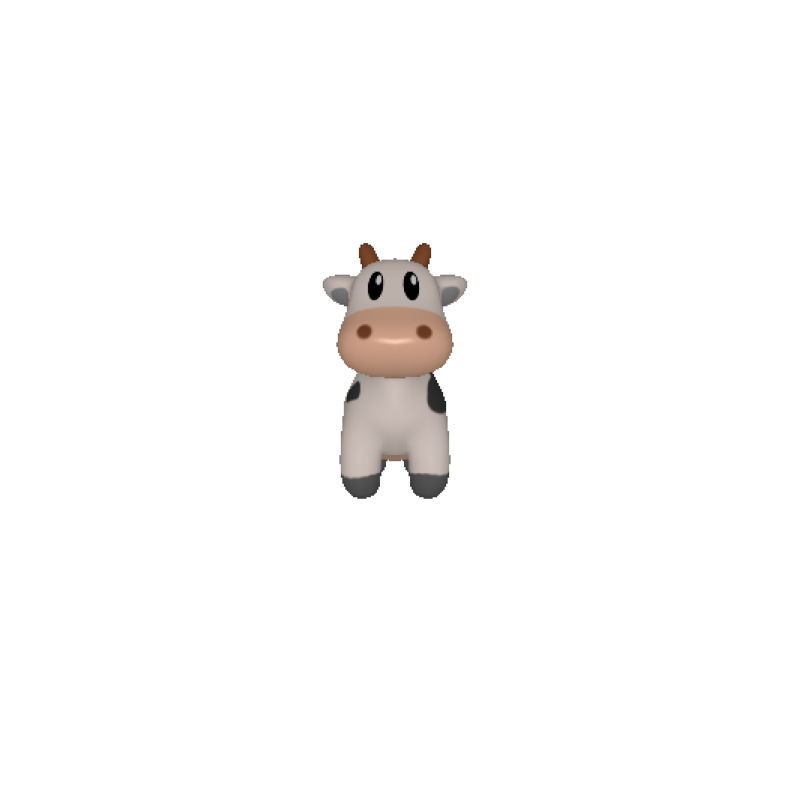

In [10]:
images = renderer(mesh)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")
# plt.savefig(output_folder+'light_at_front.png')
plt.show()

##  5. Changing the light source location

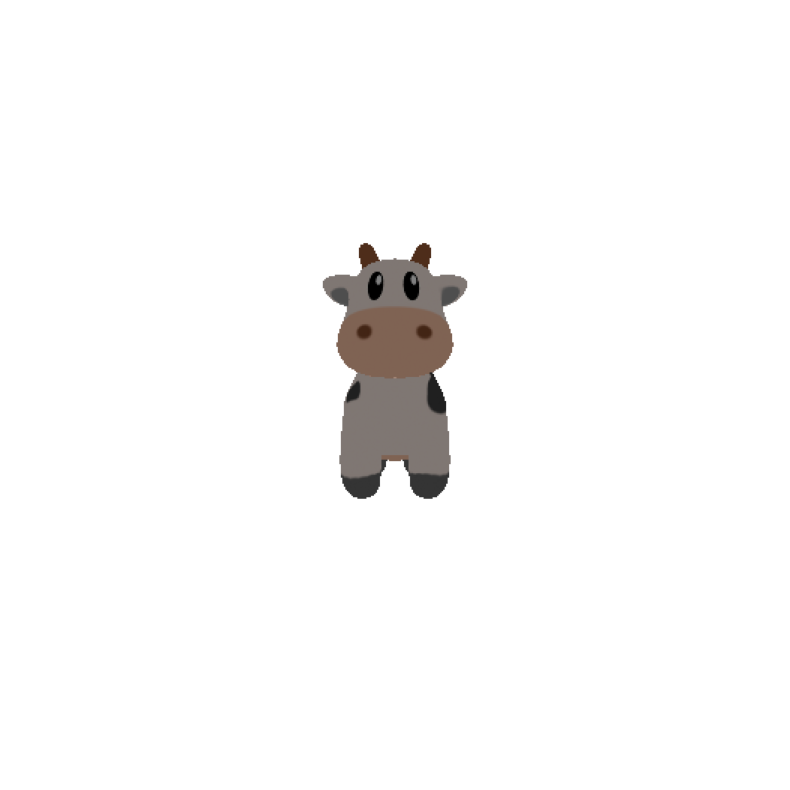

In [11]:
lights.location = torch.tensor([0.0, 0.0, +1.0], device=device)[None]
images = renderer(mesh, lights=lights, )

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")
#plt.savefig(output_folder+'light_at_back.png')
plt.show()

## 6. Experimenting with materials

In the next experiment, we are going to define a materials data structure. Here, we change the configuration so that the ambient components are close to 0 (indeed, being 0.01). Because the point light source is behind the object and the ambient light is also turned off, the rendered object does not reflect any light now. 

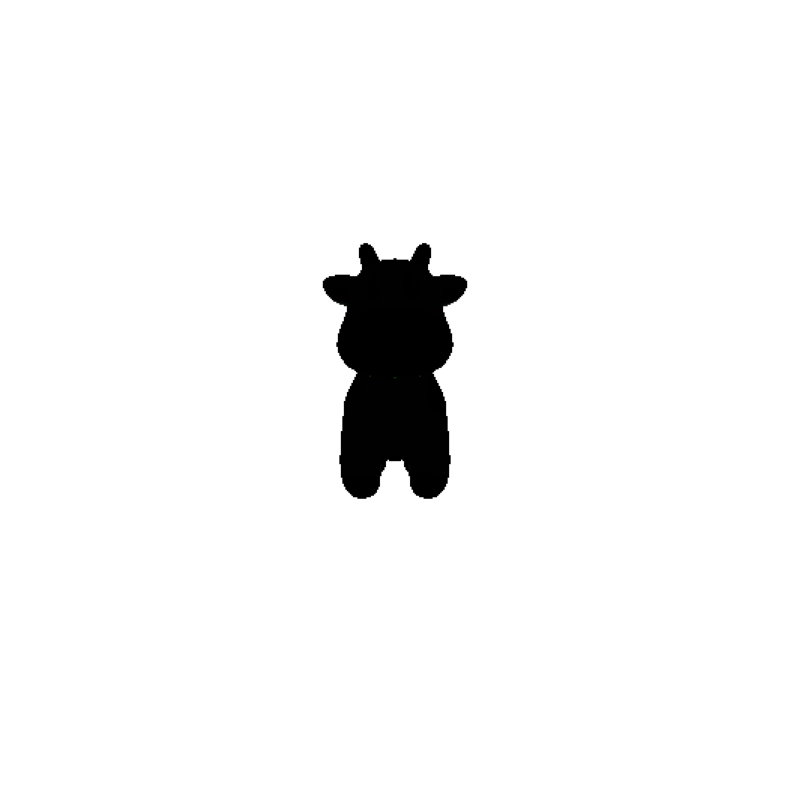

In [12]:
materials = Materials(
    device=device,
    specular_color=[[0.0, 1.0, 0.0]],
    shininess=10.0,
    ambient_color=((0.01, 0.01, 0.01),),
)
images = renderer(mesh, lights=lights, materials =
materials)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")
#plt.savefig(output_folder+'dark.png')
plt.show()

## 7. Rotating the camera and redefining the light source location

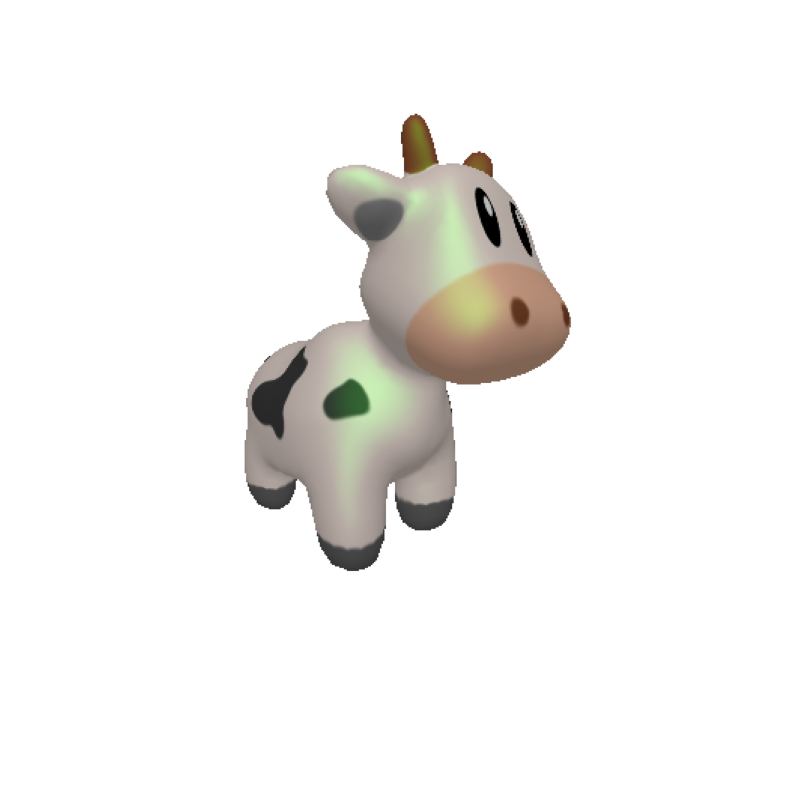

In [13]:
R, T = look_at_view_transform(dist=1.7, elev=10, azim=135)
cameras = PerspectiveCameras(device=device, R=R, T=T)

lights.location = torch.tensor([[2.0, 2.0, -2.0]], device=device)

materials = Materials(
    device=device,
    specular_color=[[0.0, 1.0, 0.0]],
    shininess=2.0
)

images = renderer(mesh, lights=lights, materials=materials, cameras=cameras)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")
#plt.savefig(output_folder+'green.png')
plt.show()